In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
import json
import spacy
import warnings
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, classification_report
import scikitplot as skplt
from datasets import Dataset
from transformers import DataCollatorWithPadding, pipeline
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json('News_Category_Dataset_v3.json', lines = True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [3]:
df.isna().any()

link                 False
headline             False
category             False
short_description    False
authors              False
date                 False
dtype: bool

# EDA

Удалим столбцы **link, date, authors** - последний приведёт к переобучению, в остальных нет необходимости.

In [4]:
df = df.drop(['link', 'date', 'authors'], axis=1)

In [5]:
df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


In [6]:
df.describe()

,headline,category,short_description
count,209527,209527,209527
unique,207996,42,187022
top,Sunday Roundup,POLITICS,
freq,90,35602,19712


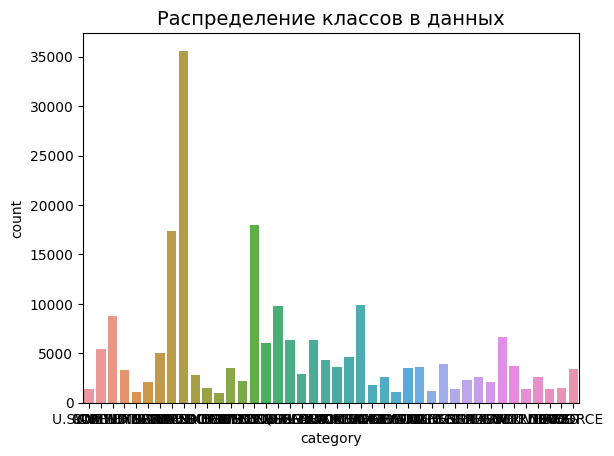

In [7]:
sns.countplot(x = df['category'])
plt.title('Распределение классов в данных', fontsize =14)
plt.show()

Упростим задачу и удалим категории, в которых меньше 7000 экземпляров на класс.

In [8]:
category_counts = df['category'].value_counts()
min_count = 7000
categories_to_drop = category_counts[category_counts < min_count].index.tolist()
df = df[~df['category'].isin(categories_to_drop)]

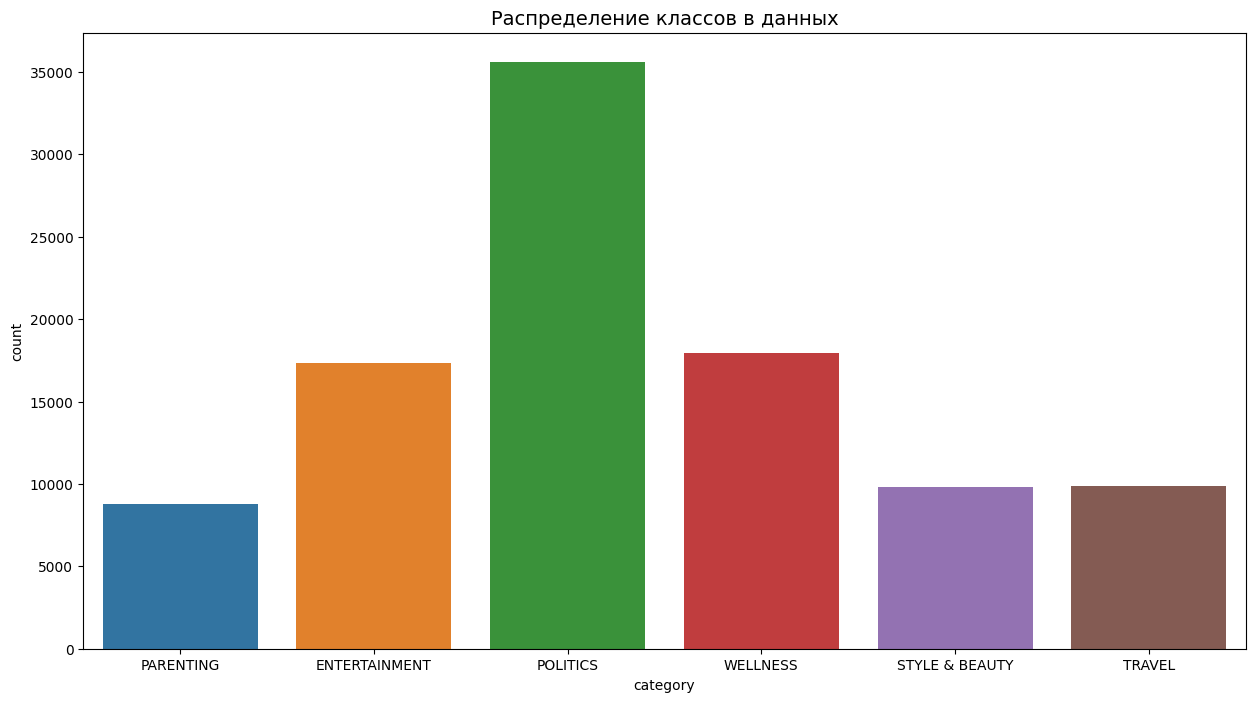

In [9]:
plt.figure(figsize=(15,8))
sns.countplot(x = df['category'])
plt.title('Распределение классов в данных', fontsize =14)
plt.show()

Объединим заголовки и описание новостей.

In [10]:
df['text'] = df['headline'] + df['short_description']

In [53]:
df['char_count'] = [len(text) for text in df['text']]
df['word_count'] = [len(text.split()) for text in df['text']]
df['sent_count'] = [len(sent_tokenize(text)) for text in df['text']]

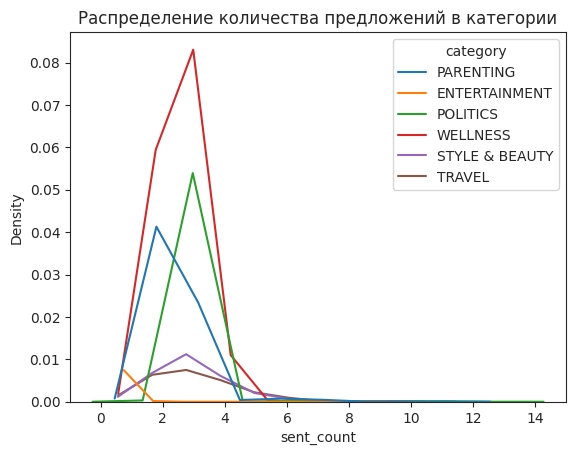

In [57]:
sns.set_style("ticks")
plt.rcParams["figure.facecolor"] = (0.0, 0.0, 0.0, 0.0)  
sns.kdeplot(x='sent_count', hue='category', data=df, palette=sns.color_palette()[:6], gridsize=10)
plt.title('Распределение количества предложений в категории')
plt.show()

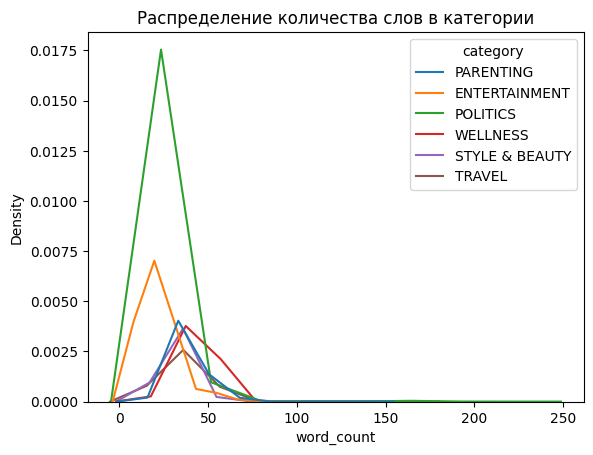

In [56]:
plt.rcParams["figure.facecolor"] = (0.0, 0.0, 0.0, 0.0)  
sns.kdeplot(x='word_count', hue='category', data=df, palette=sns.color_palette()[:6], gridsize=10)
plt.title('Распределение количества слов в категории')
plt.show()

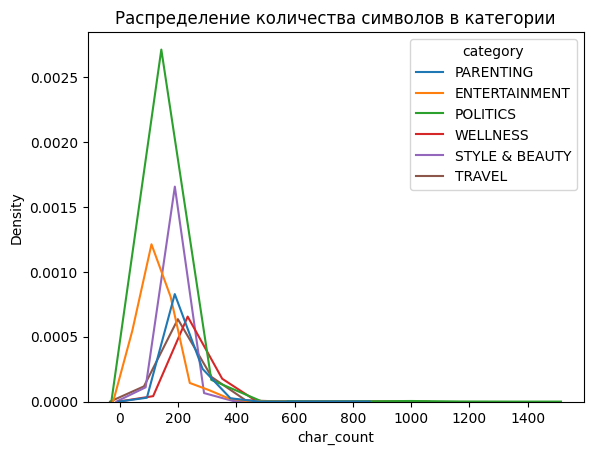

In [55]:
plt.rcParams["figure.facecolor"] = (0.0, 0.0, 0.0, 0.0) 
sns.kdeplot(x='char_count', hue='category', data=df, palette=sns.color_palette()[:6], gridsize=10)
plt.title('Распределение количества символов в категории')
plt.show()

In [15]:
def clean_text(text, nlp, lemm=False):
    cleaned_text = []
    for doc in tqdm(nlp.pipe(text, n_process=-1)):
        tmp = []
        for token in doc:
            if token.is_alpha and not token.is_stop: 
                if lemm:
                    tmp.append(token.lemma_.lower())
                else:
                    tmp.append(token.text.lower())
        cleaned_text.append(tmp)
    return cleaned_text

Отбрасываем всё, кроме слов вне стоп-листа.

In [16]:
def top_word_cloud(data, cls, words_n):
    plt.rcParams["figure.facecolor"] = (0.0, 0.0, 0.0, 0.0)  
    mostcommon = FreqDist(data['text'][data['category'] == cls].explode().values).most_common(words_n)
    wordcloud = WordCloud(width=1600, height=800, background_color=None, mode='RGBA').generate(str(mostcommon))
    fig = plt.figure(figsize=(30,10), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f'Top {words_n} Most Common Words in Class {cls}', fontsize=100)
    plt.tight_layout(pad=0)
    plt.show()

In [45]:
#!python3 -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg", disable = ['parser','ner'])

In [30]:
try:
    df_cleaned = pd.read_pickle("df_cleaned.pkl")
    not_cached = 0
except:
    not_cached = 1 

In [ ]:
if not_cached:
    df_cleaned = df.copy()
    df_cleaned['text'] = clean_text(df_cleaned['text'], nlp)
    df_cleaned.to_pickle('df_cleaned.pkl')

In [20]:
df_cleaned['text'].iloc[0]

['funniest',
 'tweets',
 'parents',
 'week',
 'grown',
 'toothpaste',
 'toddler',
 'toothbrush',
 'screamed',
 'like',
 'cleaning',
 'teeth',
 'carolina',
 'reaper',
 'dipped',
 'tabasco',
 'sauce']

In [21]:
df['text'].iloc[0]

'The Funniest Tweets From Parents This Week (Sept. 17-23)"Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce."'

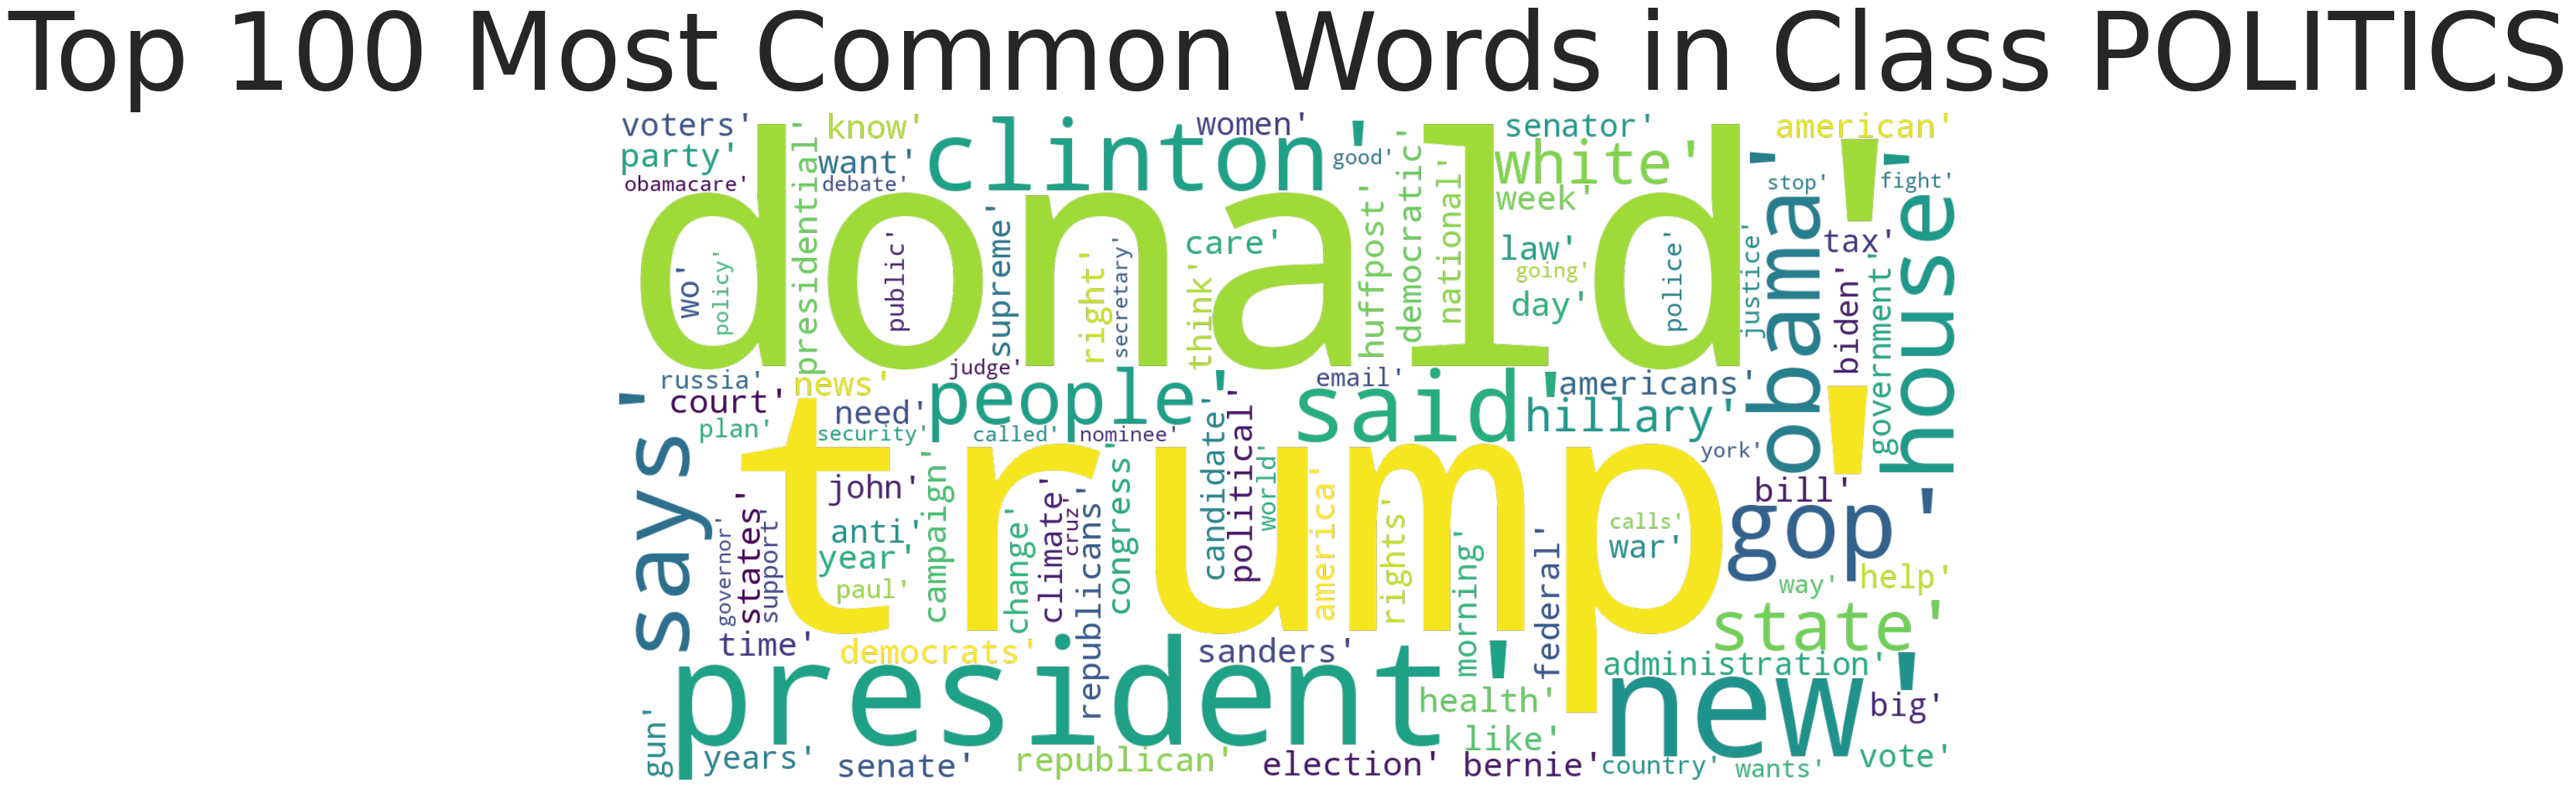

In [22]:
top_word_cloud(df_cleaned,'POLITICS',100)

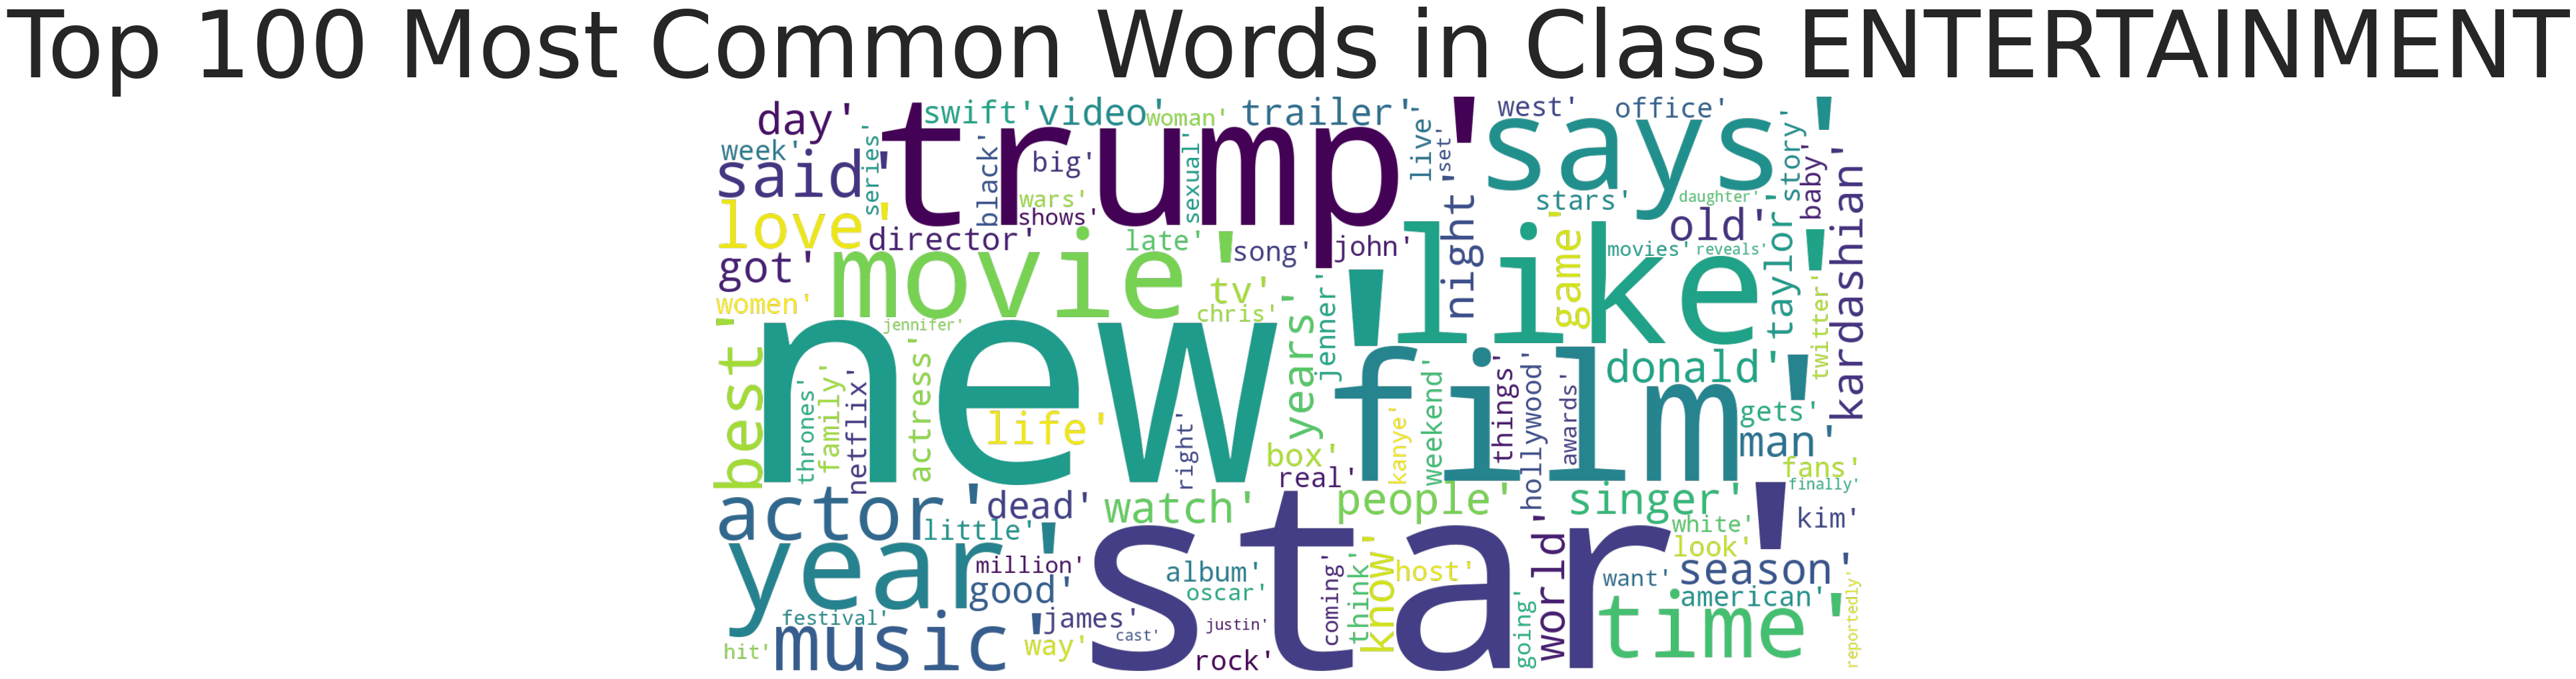

In [23]:
top_word_cloud(df_cleaned,'ENTERTAINMENT',100)

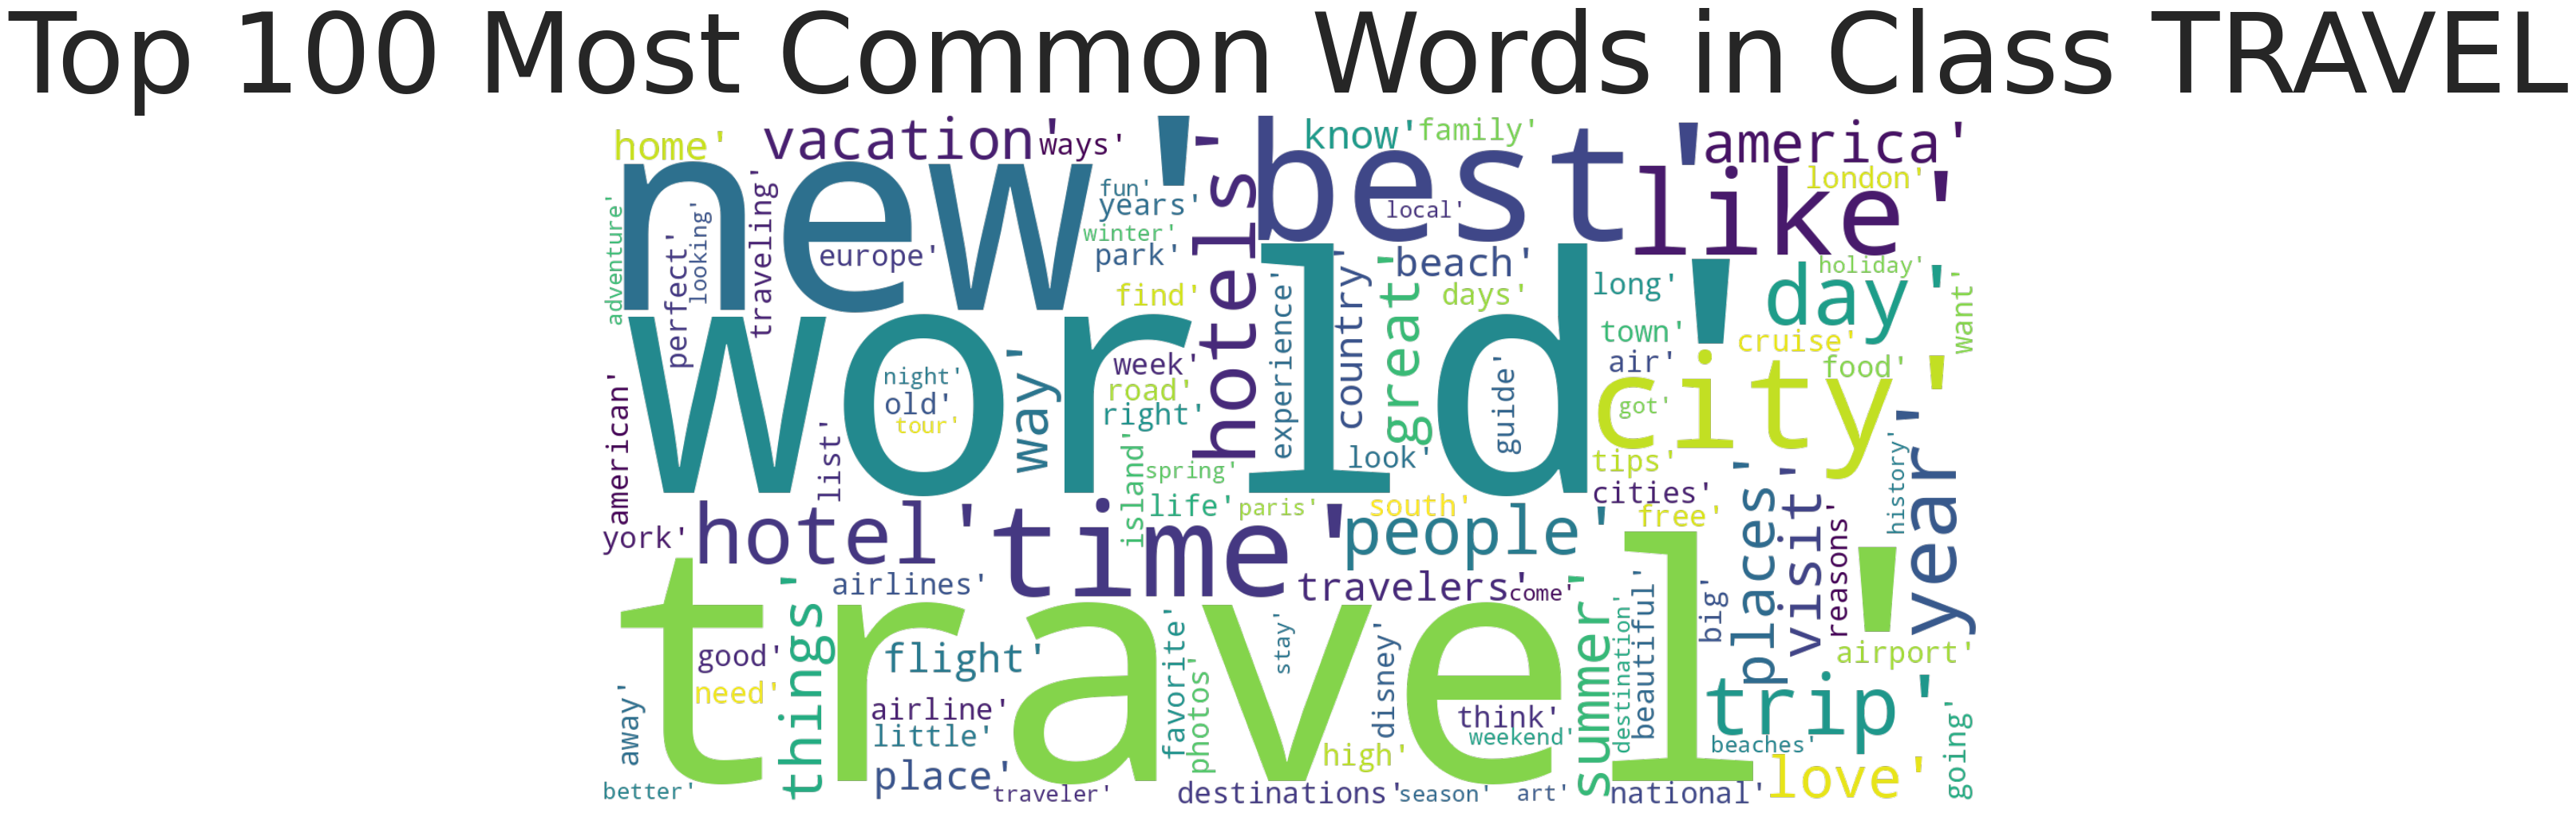

In [24]:
top_word_cloud(df_cleaned,'TRAVEL',100)

# word embeddings

## Word2Vec

In [25]:
def document_vector(text, model):
    word_vectors = [model.wv[word] for word in text if word in model.wv]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [33]:
class_mapping = {'PARENTING': 0, 'ENTERTAINMENT': 1, 'POLITICS': 2, 'WELLNESS': 3, 'STYLE & BEAUTY':4, 'TRAVEL':5}
df_cleaned['Class'] = df_cleaned['category'].map(class_mapping)

In [27]:
word2vec_model = Word2Vec(df_cleaned['text'], vector_size=100, window=5, min_count=1, seed=42, workers=4)
df_cleaned['text_vectors'] = df_cleaned['text'].apply(lambda text: document_vector(text, word2vec_model))

In [28]:
X = np.vstack(df_cleaned['text_vectors'])
y = df_cleaned['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
clf = SGDClassifier(random_state=42, n_jobs=-1, loss='log')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)
print('SGD F1 score Word2Vec:', f1_score(y_test, y_pred, average='weighted'),'\n')
print(classification_report(y_test, y_pred))

SGD F1 score Word2Vec: 0.7716187198084551 

              precision    recall  f1-score   support

           0       0.75      0.56      0.64      1758
           1       0.74      0.68      0.71      3472
           2       0.88      0.87      0.88      7121
           3       0.66      0.85      0.74      3589
           4       0.72      0.71      0.72      1963
           5       0.76      0.71      0.74      1980

    accuracy                           0.77     19883
   macro avg       0.75      0.73      0.74     19883
weighted avg       0.78      0.77      0.77     19883



Классы с наименьшим количеством экземпляров определяются хуже. Интересная ситуация складывается с классами 1 (*ENTERTAINMENT*) и 3 (*WELLNESS*). При примерно равной "представленности" классов, точность и полнота противоположны между классами. Так, *WELLNESS* имеет большую долю "узнаваемости" классификаторами, чем *ENTERTAINMENT*. И наоборот, классификаторы уверены больше в *ENTERTAINMENT*, чем в *WELLNESS*.

Почему так? По графикам выше, можно увидеть, что тексты в категории *WELLNESS* в среднем имеют больше предложений, слов и символов. Однако, распределения этих параметров у *ENTERTAINMENT* смещены влево относительно других классов, что делает эту категорию более уникальной в этом плане. 

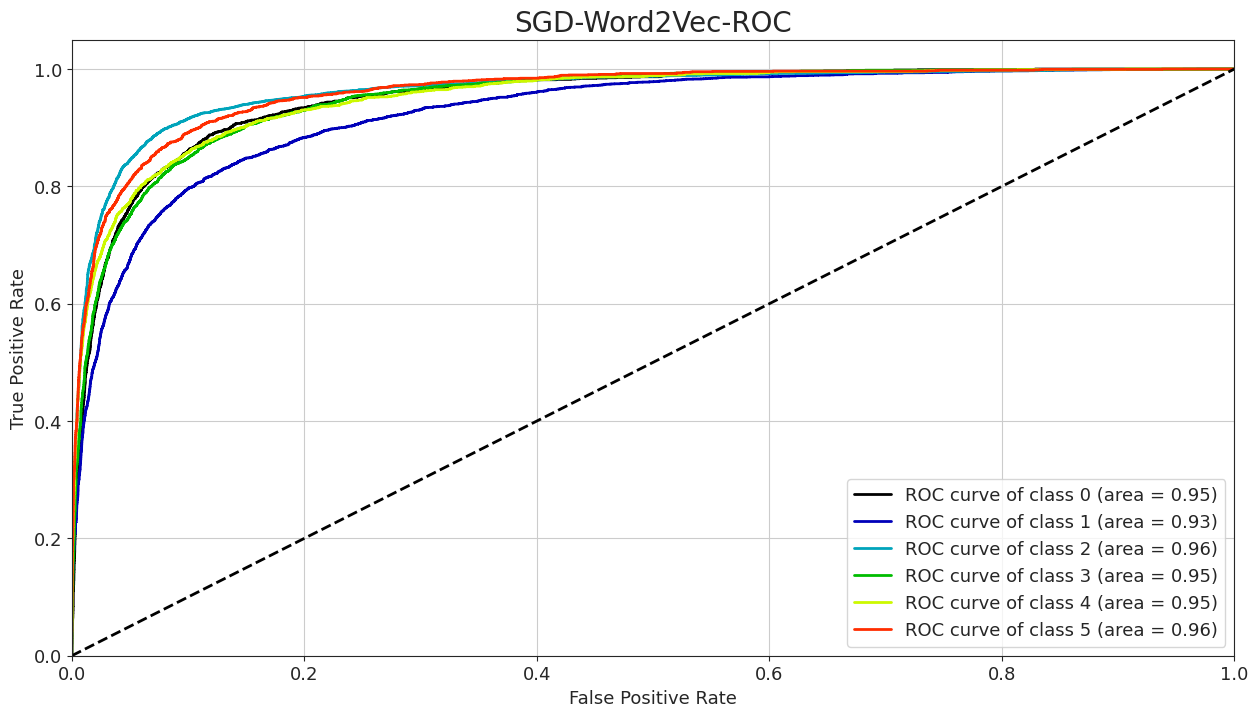

In [30]:
plt.rcParams["figure.facecolor"] = (0.0, 0.0, 0.0, 0.0) 
skplt.metrics.plot_roc(y_test, y_probs, plot_micro=False,
                       plot_macro=False, figsize=(15,8),
                       title_fontsize=20, text_fontsize=13,
                       title='SGD-Word2Vec-ROC')
plt.grid()
plt.show()

## TfidfVectorizer

In [43]:
def my_tokenizer(doc):
    tmp = []
    for token in nlp(doc):
        if token.is_alpha and not token.is_stop:
            tmp.append(token.text.strip())
    return tmp

In [32]:
df_cleaned

,headline,category,short_description,text,char_count,word_count,sent_count
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...","[funniest, tweets, parents, week, grown, tooth...",215,33,1
20,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...","[golden, globes, returning, nbc, january, year...",226,34,1
21,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,"[biden, says, forces, defend, taiwan, china, i...",108,17,2
24,‘Beautiful And Sad At The Same Time’: Ukrainia...,POLITICS,An annual celebration took on a different feel...,"[beautiful, sad, time, ukrainian, cultural, fe...",190,31,1
28,James Cameron Says He 'Clashed' With Studio Be...,ENTERTAINMENT,"The ""Avatar"" director said aspects of his 2009...","[james, cameron, says, clashed, studio, avatar...",188,28,1
...,...,...,...,...,...,...,...
209479,This Is Only the Beginning: Surprising Advice ...,WELLNESS,"My great-aunt Ida loves to say, ""This is only ...","[beginning, surprising, advice, centenarianmy,...",350,58,3
209480,Cheryl Tiegs In A Sauna: A Look Back,STYLE & BEAUTY,"""A Look Back"" is a daily column that highlight...","[cheryl, tiegs, sauna, look, look, daily, colu...",156,28,2
209481,Teen Responsibility Doesn't Happen -- It's Nur...,PARENTING,Do you feel kids today are as responsible as k...,"[teen, responsibility, happen, nurtureddo, fee...",194,32,2
209512,"Sundance, Ice-T, and Shades of the American Ra...",ENTERTAINMENT,Representation of the collective diaspora has ...,"[sundance, ice, t, shades, american, race, cin...",262,41,2


In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['text'].astype(str), df_cleaned['Class'],
                                                    test_size=0.2, random_state=42, stratify=df_cleaned['Class'])

In [33]:
%%time
tfidf = TfidfVectorizer(tokenizer = my_tokenizer, lowercase=True)
X_train_vect_good = tfidf.fit_transform(X_train)
X_test_vect_good = tfidf.transform(X_test)

CPU times: user 5min 56s, sys: 164 ms, total: 5min 56s
Wall time: 5min 56s


In [34]:
clf = SGDClassifier(random_state=42, n_jobs=-1, loss='log')
clf.fit(X_train_vect_good, y_train)
y_pred = clf.predict(X_test_vect_good)
y_probs = clf.predict_proba(X_test_vect_good)
print('SGD F1 score Tfidf:', f1_score(y_test, y_pred, average='weighted'),'\n')
print(classification_report(y_test, y_pred))

SGD F1 score Tfidf: 0.8096446088976441 

              precision    recall  f1-score   support

           0       0.83      0.59      0.69      1758
           1       0.79      0.76      0.78      3472
           2       0.81      0.96      0.88      7121
           3       0.76      0.86      0.81      3589
           4       0.92      0.66      0.77      1963
           5       0.91      0.64      0.75      1980

    accuracy                           0.82     19883
   macro avg       0.84      0.75      0.78     19883
weighted avg       0.82      0.82      0.81     19883



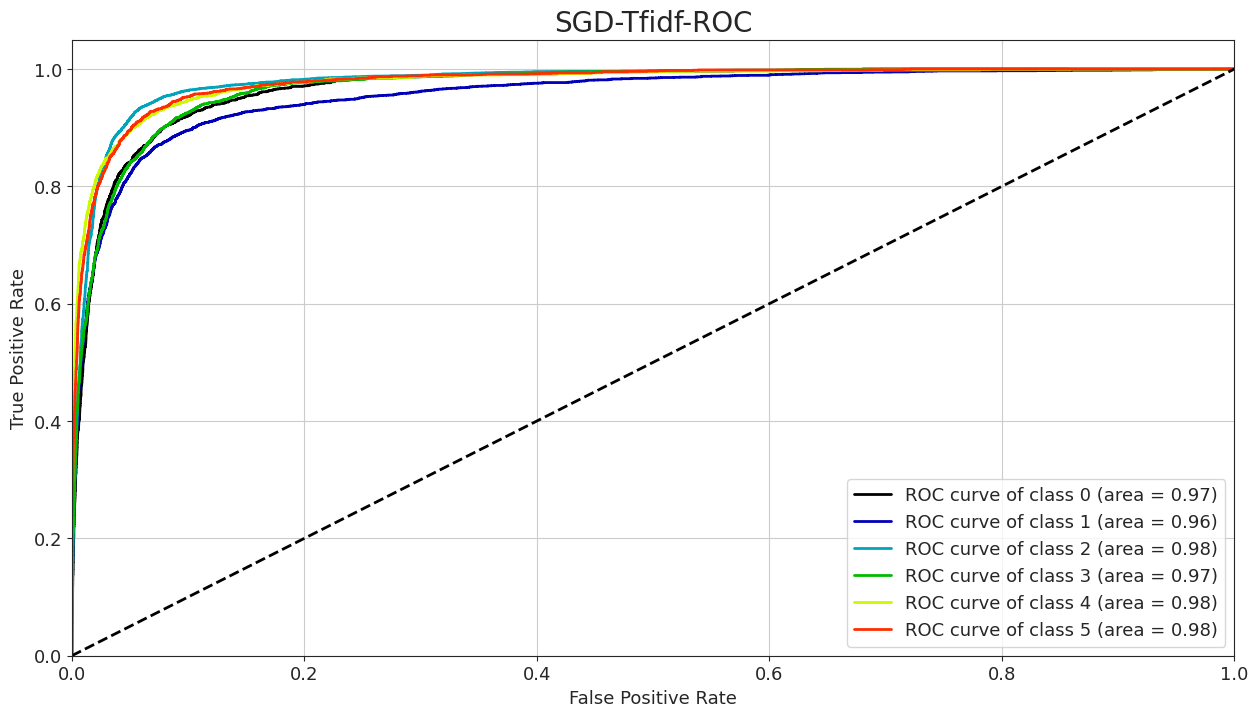

In [35]:
plt.rcParams["figure.facecolor"] = (0.0, 0.0, 0.0, 0.0) 
skplt.metrics.plot_roc(y_test, y_probs, plot_micro=False,
                       plot_macro=False, figsize=(15,8),
                       title_fontsize=20, text_fontsize=13,
                       title='SGD-Tfidf-ROC')
plt.grid()
plt.show()

## CountVectorizer

In [46]:
Count_Vect = CountVectorizer(tokenizer = my_tokenizer, lowercase=True)
X_train_vect_good = Count_Vect.fit_transform(X_train)
X_test_vect_good = Count_Vect.transform(X_test)

In [40]:
clf = SGDClassifier(random_state=42, n_jobs=-1, loss='log')
clf.fit(X_train_vect_good, y_train)
y_pred = clf.predict(X_test_vect_good)
y_probs = clf.predict_proba(X_test_vect_good)
print('SGD F1 score CountVect:', f1_score(y_test, y_pred, average='weighted'),'\n')
print(classification_report(y_test, y_pred))

SGD F1 score CountVect: 0.8673390404389176 

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1758
           1       0.82      0.84      0.83      3472
           2       0.91      0.95      0.93      7121
           3       0.84      0.87      0.85      3589
           4       0.90      0.81      0.85      1963
           5       0.88      0.80      0.84      1980

    accuracy                           0.87     19883
   macro avg       0.86      0.83      0.85     19883
weighted avg       0.87      0.87      0.87     19883



Более простое моделирование языка оказалось более эффективным. Возможно из-за малого количества текста в примерах.

In [28]:
def my_classifier(cls, X_train, X_test, y_train):                  
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_test)
    return y_pred

In [36]:
model_names=['SGDClassifier', 'Naive Bayes', 'Logistic Regression', 'LinearSVC', 'KNN', 'Random Forest']

In [48]:
df_scores=pd.DataFrame(columns=model_names, index=sorted(y_test.unique()))

In [40]:
models=[SGDClassifier(random_state=42, n_jobs=-1, loss='log'),
        MultinomialNB(),
        LogisticRegression(random_state=42, n_jobs=-1),
        LinearSVC(random_state=42),
        KNeighborsClassifier(n_jobs=-1),
        RandomForestClassifier(random_state=42, n_jobs=-1)
       ]

In [49]:
for i in tqdm(range(len(model_names))):
    y_pred = my_classifier(models[i], X_train_vect_good, X_test_vect_good, y_train)
    df_scores[model_names[i]] = f1_score(y_test, y_pred, average=None)

  0%|          | 0/6 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

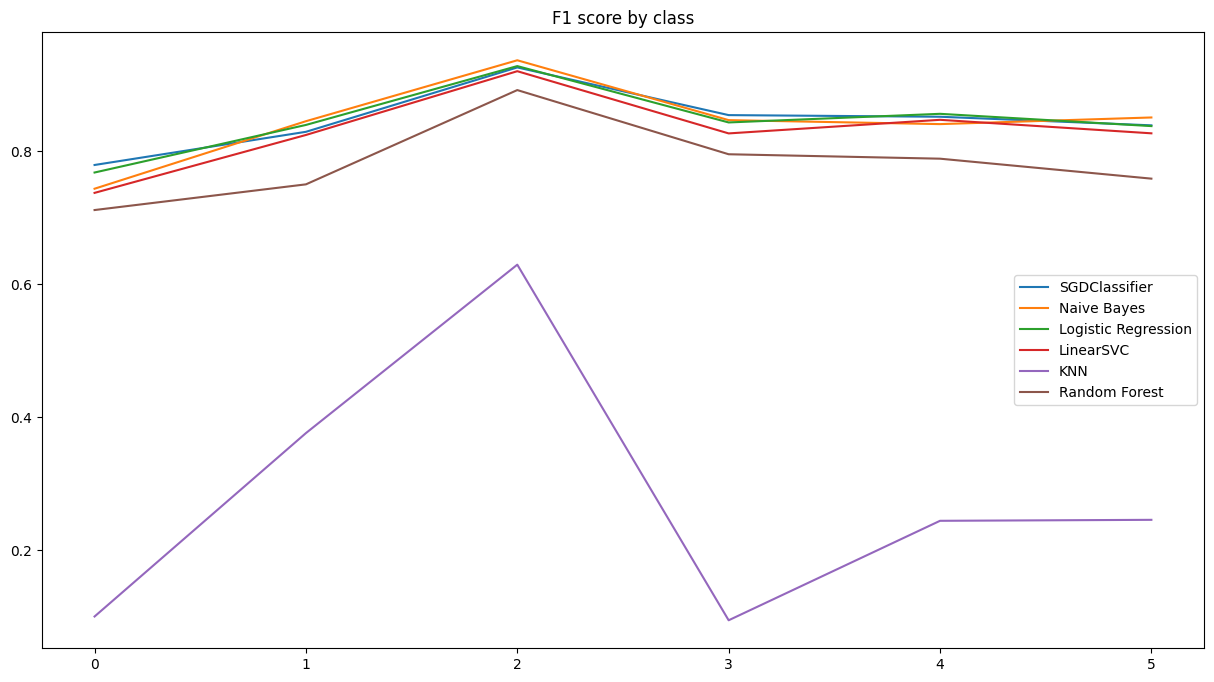

In [52]:
plt.rcParams["figure.facecolor"] = (0.0, 0.0, 0.0, 0.0) 
df_scores.plot(figsize=(15, 8), kind='line')
plt.savefig("scores1.png", transparent=True)
plt.title('F1 score by class')
plt.show()

# BERT

In [11]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [12]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [14]:
!rocm-smi --showproductname --showmeminfo vram



======================= ROCm System Management Interface =======================
============================= Memory Usage (Bytes) =============================
GPU[0]		: VRAM Total Memory (B): 8573157376
GPU[0]		: VRAM Total Used Memory (B): 941940736
================================= Product Info =================================
GPU[0]		: Card series: 		Vega 10 XL/XT [Radeon RX Vega 56/64]
GPU[0]		: Card model: 		Radeon RX VEGA 56 Pulse 8GB OC HBM2
GPU[0]		: Card vendor: 		Advanced Micro Devices, Inc. [AMD/ATI]
GPU[0]		: Card SKU: 		376XL
============================= End of ROCm SMI Log ==============================


In [15]:
f1_metric = evaluate.load('f1')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1_metric.compute(predictions=predictions, references=labels, average='weighted')

In [16]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [17]:
class_mapping = {'PARENTING': 0, 'ENTERTAINMENT': 1, 'POLITICS': 2, 'WELLNESS': 3, 'STYLE & BEAUTY':4, 'TRAVEL':5}
df['label'] = df['category'].map(class_mapping)

In [18]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df['text'].astype(str), df['label'],
                                                    test_size=0.2, random_state=42, stratify=df['label'])

In [19]:
df_train = pd.concat([X_train_b, y_train_b], axis=1)
df_test = pd.concat([X_test_b, y_test_b], axis=1)
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

In [20]:
df_train

,text,label
79596,Carrie Underwood Shares Sweet Snap Of Her Husb...,1
185139,"Kids Burned By Hair Straighteners On The Rise,...",0
53561,Just How Many More Profiles Of Huma Abedin Do ...,2
7218,10 Bags On Sale For Under $100 During The Nord...,4
195009,Bliss Is the New BlackIf there's anything that...,3
...,...,...
192263,Louder Than WordsA few weeks ago my Aunt Leona...,3
160094,Jimmy Kimmel Talks To Kids: Who Is The Richest...,0
165537,The 12 Trendiest Hotel Bars Across the U.S. (P...,5
26639,Why Going Abroad Isn’t Always Rainbows And But...,5


In [21]:
train_tokenized = train_dataset.map(preprocess_function, batch_size=32, keep_in_memory=True)
test_tokenized = test_dataset.map(preprocess_function, batch_size=32, keep_in_memory=True)

Map:   0%|          | 0/79531 [00:00<?, ? examples/s]

Map:   0%|          | 0/19883 [00:00<?, ? examples/s]

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=6)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
import os
os.environ['WANDB_SILENT']="true"

In [25]:
training_args = TrainingArguments(
    output_dir="./hf_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    push_to_hub=False,
    eval_steps=2000,
    save_steps=2000,
    #gradient_accumulation_steps=4
    
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1
2000,0.285500,0.263446,0.922526
4000,0.249100,0.254603,0.926709
6000,0.154500,0.276656,0.933378
8000,0.147000,0.269796,0.935335
10000,0.153800,0.267659,0.935294
12000,0.091500,0.299102,0.934925
14000,0.094200,0.307626,0.935612
16000,0.045100,0.346667,0.936304
18000,0.049500,0.361742,0.936086
20000,0.044800,0.368235,0.935881


TrainOutput(global_step=24855, training_loss=0.128362653375847, metrics={'train_runtime': 2858.9165, 'train_samples_per_second': 139.093, 'train_steps_per_second': 8.694, 'total_flos': 7827489530633628.0, 'train_loss': 0.128362653375847, 'epoch': 5.0})

In [26]:
trainer.evaluate()

{'eval_loss': 0.25460273027420044,
 'eval_f1': 0.9267094611529697,
 'eval_runtime': 34.6561,
 'eval_samples_per_second': 573.723,
 'eval_steps_per_second': 35.867,
 'epoch': 5.0}

# Вывод

Среди "простых" моделей лучший результат получается на более простой обработке текста (Count Vectorizer). Возможно, Word2Vec даст такой же результат (или лучше), если продолжить его настраивать, т.к БЕРТ со своей обработкой выдаёт результат сильно выше.